In [326]:
# Loading libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot

In [327]:
# Import the dataset
kickstarter = pd.read_excel('Kickstarter.xlsx')

In [384]:
# For the purpose of this project, we only need to include projects with "successful" or "failure" state
df = kickstarter[kickstarter['state'].isin(['successful','failed'])]

# Convert the target variable to binary
df['state'] = df['state'].replace(['successful','failed'],[1,0])

# Convert goal to usd_goal = goal * static_usd_rate
df['usd_goal'] = df['goal'] * df['static_usd_rate']
df = df.drop(columns = 'goal')

df.head()

C:\Users\shans\AppData\Local\Temp\ipykernel_17416\263580240.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'] = df['state'].replace(['successful','failed'],[1,0])
C:\Users\shans\AppData\Local\Temp\ipykernel_17416\263580240.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['usd_goal'] = df['goal'] * df['static_usd_rate']


,id,name,pledged,state,disable_communication,country,currency,deadline,state_changed_at,created_at,...,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,usd_goal
0,1601563193,Our future,1.00,0,False,AU,AUD,2014-10-07 12:05:39,2014-10-07 12:05:39,2014-08-01 21:22:10,...,2014,21,8,8,2014,12,6,60,60,9.289424e+07
1,880009511,Elite: Dangerous,1578316.08,1,False,GB,GBP,2013-01-04 18:00:57,2013-01-04 18:00:57,2012-10-31 11:08:38,...,2012,11,11,5,2012,18,5,60,60,2.003273e+06
4,557230947,"Bring Reading Rainbow Back for Every Child, Ev...",5408916.95,1,False,US,USD,2014-07-02 14:00:00,2014-07-02 14:00:11,2014-04-22 22:00:21,...,2014,22,5,28,2014,8,35,35,35,1.000000e+06
5,1966069095,ARKYD: A Space Telescope for Everyone,1505366.60,1,False,US,USD,2013-06-30 21:00:00,2013-06-30 21:00:34,2012-07-10 17:20:54,...,2012,17,5,29,2013,10,322,32,32,1.000000e+06
6,2083255961,A Billion Pixels...,56.00,0,False,US,USD,2014-08-04 16:39:34,2014-08-04 16:39:34,2014-05-01 16:47:47,...,2014,16,6,5,2014,16,34,60,60,1.000000e+08


# 1. Data Preprocessing

In [ ]:
# Check the number of rows and columns 
df.shape

### 1.1 Detect Duplicated Records

In [ ]:
# Check if there is any duplicated records
df = df.drop_duplicates()

### 1.2 Drop out-of-scope predictors

According to the project instruction, we can only use the predictors "that are available at the moment when a new project is launched."
Therefore, we do not need any predictors regarding 'states' of the project.

In [385]:
df = df.drop(columns = ['state_changed_at','state_changed_at_weekday','state_changed_at_month', 'state_changed_at_day', 'state_changed_at_yr','state_changed_at_hr','launch_to_state_change_days'])

The information about pledged, staff_pick, backers_count, spotlight wont be available at the moment when the project is launched. Therefore, we remove them as well.

In [386]:
df = df.drop(columns = ['pledged','usd_pledged','staff_pick','backers_count','spotlight'])

### 1.3 Identify unique identifiers

Look at the number of unique values in each column

In [ ]:
df.nunique()

Note that disable_communication only have one unique value, so it won't be useful for our prediction.

[id, name, deadline, created_at, launched_at] are almost a unique identifier, so we should drop them as well.

In [387]:
df= df.drop(columns = ['disable_communication','id','name','deadline', 'created_at', 'launched_at'])

### 1.4 Handle with Missing Values

In [ ]:
# Check if there is any missing values
missing_values = np.where(pd.isnull(df))

# Identify the columns that contain missing values
df.columns[list(set(np.where(pd.isnull(df))[1]))]

In [ ]:
# Count the percentage of missing values
len(missing_values[0]) / df.shape[0]

10% of missing values is not that small. Let's try look into the column.

In [ ]:
df['category'].unique()

Instead of dropping the missing values, we can replace the null value with 'Unknown'.

In [332]:
df['category'] = df['category'].fillna('Unknown')
df.shape

(13435, 27)

### 1.5 Detect collinearity between variables

In [ ]:
# check if there is any collinearity between variables
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(26, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.savefig('heatmap_classification.png', dpi=300, bbox_inches='tight')

According to the correlation heatmap, following varaibles have high correlation:
- name_len and name_len_clean, 
- blurb_len and blurb_len_clean,
- deadline_yr and created_at_yr and launched_at_yr

For each pair, we only need to keep one of them.

In [388]:
df = df.drop(columns = ['name_len_clean','blurb_len_clean','created_at_yr', 'launched_at_yr'])

In [ ]:
df.describe()
import seaborn as sns
sns.boxplot(x=df['usd_goal'])

In [ ]:
df = df.drop(df[df['usd_goal'] > 60000000].index )
df.shape

In [ ]:
df['state'].value_counts()

### 1.6 Handle Categorical Variables

In [ ]:
# Check variable types
df.dtypes

In [389]:
# For 'weekday' variables. convert them into numerical variable from 1-7
cols = ['deadline_weekday','created_at_weekday','launched_at_weekday']
df[cols] = df[cols].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])

In [394]:
df['category'].value_counts()

Hardware        2348
Web             2148
Software        1833
Gadgets         1244
Plays            827
Apps             742
Musical          548
Wearables        503
Festivals        326
Robots           312
Sound            266
Flight           247
Experimental     226
Immersive        190
Makerspaces      127
Spaces           116
Places            84
Shorts            38
Webseries         18
Academic          15
Thrillers         13
Blues             10
Name: category, dtype: int64

In [397]:
df = pd.get_dummies(df, columns = ['country','currency','category'])
df.head()

,state,static_usd_rate,name_len,blurb_len,deadline_weekday,created_at_weekday,launched_at_weekday,deadline_month,deadline_day,deadline_yr,...,category_Plays,category_Robots,category_Shorts,category_Software,category_Sound,category_Spaces,category_Thrillers,category_Wearables,category_Web,category_Webseries
0,0,0.928942,2.0,24.0,2,5,5,10,7,2014,...,0,0,0,0,0,0,0,0,0,0
1,1,1.602618,2.0,22.0,5,3,1,1,4,2013,...,0,0,0,0,0,0,0,0,0,0
4,1,1.000000,8.0,22.0,3,2,3,7,2,2014,...,0,0,0,0,0,0,0,0,1,0
5,1,1.000000,6.0,19.0,7,2,3,6,30,2013,...,0,0,0,0,0,0,0,0,0,0
6,0,1.000000,3.0,17.0,1,4,4,8,4,2014,...,0,0,0,0,0,0,0,0,1,0


## 2. Feature Selection

In [336]:
X = df.loc[:,df.columns != 'state']
y = df['state']

# Standardize the predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

C:\Users\shans\AppData\Local\Temp\ipykernel_17416\4153565337.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(X.columns[tree_importance_sorted_idx])


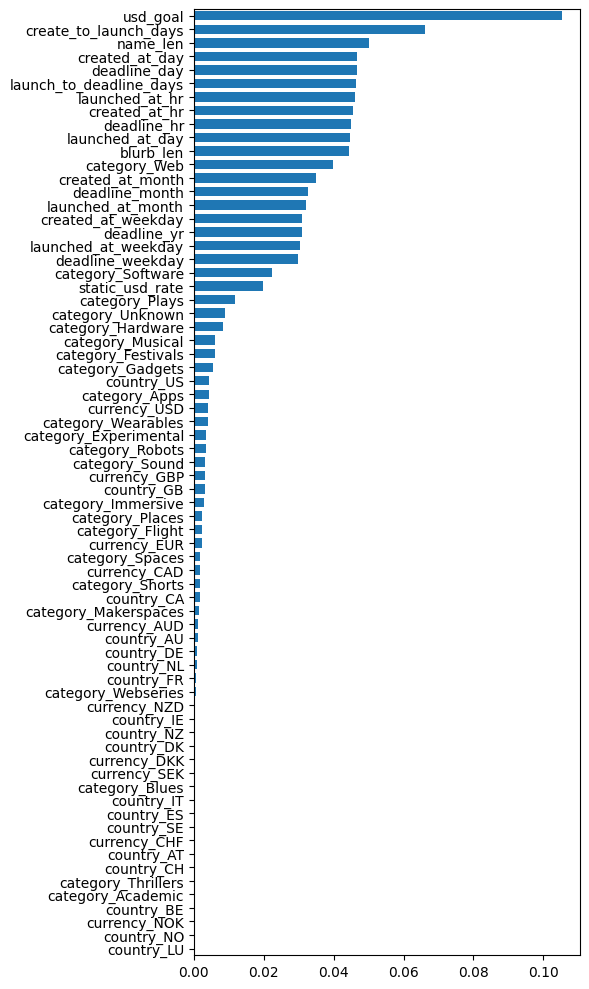

<Figure size 640x480 with 0 Axes>

In [337]:
# Feature selection using Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

rf = RandomForestClassifier(random_state=0)
model = rf.fit(X_std, y)

result = permutation_importance(rf, X_std, y, n_repeats=1,
                                random_state=0)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 10))
ax1.barh(tree_indices,
         rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(X.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(rf.feature_importances_)))

fig.tight_layout()
plt.show()
plt.savefig('RandomForest_FeatureImportance.png', dpi=300, bbox_inches='tight')

# Print feature importance
#pd.Series(model.feature_importances_, index = X.columns).sort_values(ascending = False).plot(kind = 'bar',figsize = (14,6))

# 3. Classification Models

In [402]:
X = df[['usd_goal', 'create_to_launch_days', 'name_len', 'created_at_day', 'launched_at_hr',
       'deadline_day', 'launch_to_deadline_days','created_at_hr','deadline_hr','launched_at_day']] 
#        'blurb_len', 'category_Web', 'created_at_month','launched_at_month', 'deadline_month',
 #       'created_at_weekday','launched_at_weekday','deadline_weekday', 'deadline_yr', 'category_Software',
  #      'static_usd_rate', 'category_Plays','category_Hardware','category_Festivals','category_Musical']]

#X = df.loc[:,df.columns != 'state']
y = df["state"]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.33, random_state = 5)

### 3.1 Logistic Regression

In [406]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 1000)
model_logit = lr.fit(X_train, y_train)

### 3.2 DecisionTree

In [404]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=10) # default is to grow a full tree
                                    # avoid overfitting
model_dt = dt.fit(X_train,y_train)

### 3.3 Random Forest

In [408]:
# Build the model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(oob_score=True)
model_rf = rf.fit(X_train, y_train)

model_rf.oob_score_

0.6844795022775247

### 3.4 Gradient Boosting

In [409]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier(random_state = 0)
model_gbt = gbt.fit(X_train, y_train)

### 3.5 K-Nearest Neighbors

In [410]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

accuracy = 0
bestK = 0
for i in range (1,21):
    knn = KNeighborsClassifier(n_neighbors=i)
    model = knn.fit(X_train,y_train)
    y_test_pred = model.predict(X_test)
    if accuracy_score(y_test, y_test_pred) > accuracy:
        accuracy = accuracy_score(y_test, y_test_pred)
        bestK = i
    #print("k = ", i, "accuracy =", accuracy_score(y_test, y_test_pred))

knn = KNeighborsClassifier(n_neighbors=bestK) #,  weights = 'distance')
model_knn = knn.fit(X_train, y_train)

### 3.6 Artificial Neural Network

In [ ]:
# Find the optimal size of hidden layer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
for i in range(1,21): 
    model = MLPClassifier(hidden_layer_sizes=(i), max_iter = 1000, random_state=0)
    scores = cross_val_score(model, X=X_std, y=y, cv=10)
    print(i, ":", np.average(scores))

In [411]:
from sklearn.neural_network import MLPClassifier
ann = MLPClassifier(hidden_layer_sizes=(3), random_state=0)
model_mlp = ann.fit(X_train,y_train)

C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
## Find the best hyper-parameter
from sklearn.model_selection import GridSearchCV
mlp = MLPClassifier(max_iter=5000, random_state=0)

parameter = {'hidden_layer_sizes': range(1,22)}
grid_search = GridSearchCV(estimator = mlp, param_grid= parameter, 
                           scoring = "accuracy", verbose=True)
model_mlp = grid_search.fit(X_std, y)

### 3.7 Support Vector Machine

In [ ]:
# Find the optimal gamma
from sklearn.svm import SVC
for i in range(1,11):
    svm_rbf = SVC(kernel = "rbf", random_state=0, C =0.5, gamma = i)
    model_rbf = svm_rbf.fit(X_train,y_train)
    scores = cross_val_score(model_rbf,X=X_test, y=y_test, cv=10)
    print("gamma = ",i,", score = ", sum(scores)/len(scores))

In [412]:
# Build the SVM model using a linear model
from sklearn.svm import SVC
svm = SVC(kernel="linear", random_state=0, C=0.5, gamma = 3)
model_svm = svm.fit(X_train, y_train)

### Model Performance Comparison

In [413]:
from sklearn import metrics

def model_metrics(model,X,y):
    y_pred = model.predict(X)

    accuracy = metrics.accuracy_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred)
    f1_score = metrics.f1_score(y, y_pred)

    model_metrics = [accuracy, precision, recall, f1_score]
    return model_metrics

In [414]:
model_performance = {
    'Logitstic': model_metrics(model_logit,X_test,y_test),
    'KNN': model_metrics(model_knn,X_test,y_test),

    'DecisionTree': model_metrics(model_dt,X_test,y_test),
    'RandomForest': model_metrics(model_rf,X_test,y_test),
    'GradientBoosting': model_metrics(model_gbt,X_test,y_test),

    'ANN': model_metrics(model_mlp,X_test,y_test),
    'SVM': model_metrics(model_svm,X_test,y_test)    
}

pd.DataFrame.from_dict(model_performance, orient='index',columns = ['accuracy','percision','recall','f1_score'])

C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,percision,recall,f1_score
Logitstic,0.660352,0.543103,0.123047,0.200637
KNN,0.651556,0.490196,0.146484,0.225564
DecisionTree,0.655165,0.503356,0.341797,0.407135
RandomForest,0.689896,0.584648,0.361979,0.447125
GradientBoosting,0.702075,0.614973,0.374349,0.465399
ANN,0.663058,0.540076,0.184245,0.274757
SVM,0.653586,0.000000,0.000000,0.000000


### K-Fold CV on potential classifiers

In [417]:
from sklearn.model_selection import cross_val_score

scores_log = cross_val_score(lr, X=X_std, y=y, cv=5)
scores_rf = cross_val_score(rf, X=X_std, y=y, cv=5)
scores_gbt = cross_val_score(gbt, X=X_std, y=y, cv=5)
scores_ann = cross_val_score(ann, X=X_std, y=y, cv=5)
scores_svm = cross_val_score(svm, X=X_std, y=y, cv=5)

print(scores_log, scores_rf,scores_gbt,scores_ann, scores_svm, sep='\n')

C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[0.66058802 0.67882397 0.66840342 0.65128396 0.65574991]
[0.65761072 0.36397469 0.3974693  0.21734276 0.38407146]
[0.65947153 0.27242278 0.31187198 0.16524004 0.3885374 ]
[0.67100856 0.67435802 0.67026424 0.6538891  0.65723856]
[0.65947153 0.65947153 0.65947153 0.65947153 0.65947153]


# 4. Evaluation on Grading Dataset

In [415]:
# Loading libraries
import pandas as pd
import numpy as np

# Import the dataset
grading = pd.read_excel('Kickstarter-Grading-Sample.xlsx')

# For the purpose of this project, we only need to include projects with "successful" or "failure" state
df_test = grading[grading['state'].isin(['successful','failed'])]
df_test['state'] = df_test['state'].replace(['successful','failed'],[1,0])

# Convert goal to usd_goal = goal * static_usd_rate
df_test['usd_goal'] = df_test['goal'] * df_test['static_usd_rate']
df_test = df_test.drop(columns = 'goal')

# Check if there is any duplicated records
df_test = df_test.drop_duplicates()

### Drop out-of-scope predictors
df_test = df_test.drop(columns = ['state_changed_at','state_changed_at_weekday','state_changed_at_month', 
'state_changed_at_day', 'state_changed_at_yr','state_changed_at_hr','launch_to_state_change_days',
'pledged','staff_pick','backers_count','spotlight','disable_communication',
'id','name','deadline', 'created_at', 'launched_at','usd_pledged','name_len_clean','created_at_yr', 'launched_at_yr'])

### Handle Categorical Variables
cols = ['deadline_weekday','created_at_weekday','launched_at_weekday']
df_test[cols] = df_test[cols].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])

# dummify the other categorical variables
df_test['category'] = df_test['category'].fillna('Unknown')
df_test = pd.get_dummies(df_test, columns = ['country','currency','category'])

# Testing
X_grade = df_test[['usd_goal', 'create_to_launch_days', 'name_len', 'created_at_day', 'launched_at_hr',
        'deadline_day', 'launch_to_deadline_days','created_at_hr','deadline_hr','launched_at_day']] 
#        'blurb_len', 'category_Web', 'created_at_month','launched_at_month', 'deadline_month',
#        'created_at_weekday','launched_at_weekday','deadline_weekday', 'deadline_yr', 'category_Software',
#        'static_usd_rate', 'category_Plays','category_Hardware','category_Festivals','category_Musical']]
#.loc[:,df.columns != 'state']
y_grade = df_test["state"]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_grade = scaler.fit_transform(X_grade)


### PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X_std)
# X_grade = pca.transform(X_grade)

C:\Users\shans\AppData\Local\Temp\ipykernel_17416\1339198348.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['state'] = df_test['state'].replace(['successful','failed'],[1,0])
C:\Users\shans\AppData\Local\Temp\ipykernel_17416\1339198348.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['usd_goal'] = df_test['goal'] * df_test['static_usd_rate']


PCA(n_components=3)

In [416]:
test_performance = {
    'Logitstic': model_metrics(model_logit,X_grade,y_grade),
    'KNN': model_metrics(model_knn,X_grade,y_grade),

    'DecisionTree': model_metrics(model_dt,X_grade,y_grade),
    'RandomForest': model_metrics(model_rf,X_grade,y_grade),
    'GradientBoosting': model_metrics(model_gbt,X_grade,y_grade),

    'ANN': model_metrics(model_mlp,X_grade,y_grade),
    'SVM': model_metrics(model_svm,X_grade,y_grade)
}

pd.DataFrame.from_dict(test_performance, orient='index',columns = ['accuracy','percision','recall','f1_score'])

C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,percision,recall,f1_score
Logitstic,0.669143,0.537988,0.425325,0.475068
KNN,0.656571,0.541436,0.159091,0.245922
DecisionTree,0.574857,0.423261,0.573052,0.486897
RandomForest,0.590857,0.447479,0.691558,0.543367
GradientBoosting,0.562286,0.431818,0.771104,0.553613
ANN,0.679429,0.558386,0.426948,0.483901
SVM,0.648000,0.000000,0.000000,0.000000
